In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [2]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [3]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  # 将图像的值从[0, 255]缩放到[-1, 1]之间
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  print(image.shape)
  image = image[None, ...]
  print(image.shape)
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [4]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

# print(image)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

(224, 224, 3)
(1, 224, 224, 3)
1/1 [==============================] - 0s 468ms/step


(1, 224, 224, 3)


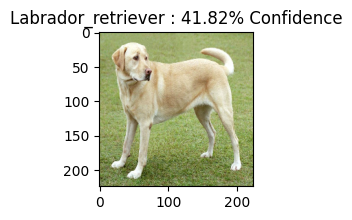

In [5]:
plt.figure(figsize=(2, 2))
print(image.shape)
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

In [6]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
#   print(gradient)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

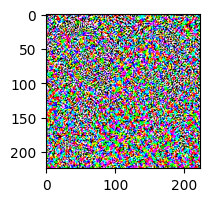

In [7]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
# print(perturbations)
plt.figure(figsize=(2, 2))
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [8]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure(figsize=(2, 2))
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

1/1 [==============================] - 0s 29ms/step


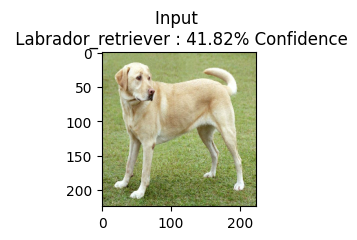

1/1 [==============================] - 0s 29ms/step


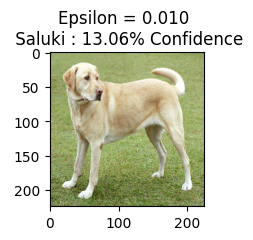

1/1 [==============================] - 0s 26ms/step


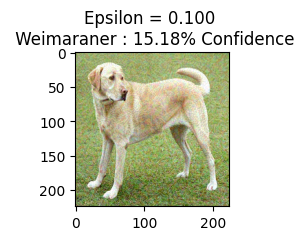

1/1 [==============================] - 0s 25ms/step


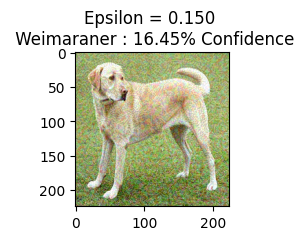

In [9]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  # print(adv_x)
  # tf.clip_by_value(A, min, max)：输入一个张量A，把A中的每一个元素的值都压缩在min和max之间。小于min的让它等于min，大于max的元素的值等于max。
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])